In [16]:
import pandas as pd

# Step 1: Load CSV with first column as datetime index, parsing dates
df = pd.read_csv('data.csv', index_col=0, parse_dates=True)

# Step 2: Check the datetime index and remove invalid datetime rows (NaT)
print(f"Total rows before dropping NaT: {len(df)}")
df = df[~df.index.isna()]
print(f"Total rows after dropping NaT: {len(df)}")

# Step 3: Convert all columns to numeric, coercing errors which become NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Step 4: Group by datetime index to handle duplicate timestamps by averaging
df = df.groupby(df.index).mean()

# Step 5: Resample to strict 5-minute intervals filling missing data forward
df_resampled = df.resample('5min').ffill()

# Step 6: View first 10 rows of resampled data
print(df_resampled.head(10))



Total rows before dropping NaT: 378719
Total rows after dropping NaT: 377719
                     Cyclone_Inlet_Gas_Temp  Cyclone_Material_Temp  \
time                                                                 
2017-01-01 00:00:00                  867.63                 910.42   
2017-01-01 00:05:00                  879.23                 918.14   
2017-01-01 00:10:00                  875.67                 924.18   
2017-01-01 00:15:00                  875.28                 923.15   
2017-01-01 00:20:00                  891.66                 934.26   
2017-01-01 00:25:00                  878.54                 932.38   
2017-01-01 00:30:00                  905.94                 951.32   
2017-01-01 00:35:00                  877.83                 939.63   
2017-01-01 00:40:00                  871.01                 938.73   
2017-01-01 00:45:00                  905.46                 939.06   

                     Cyclone_Outlet_Gas_draft  Cyclone_cone_draft  \
time         

In [17]:
# Summary statistics (count, mean, std, min, max, quartiles)
summary_stats = df_resampled.describe()

# Correlation matrix between columns
correlation_matrix = df_resampled.corr()

print(summary_stats)
print(correlation_matrix)


       Cyclone_Inlet_Gas_Temp  Cyclone_Material_Temp  \
count           377260.000000          376989.000000   
mean               727.696481             751.174154   
std                328.371416             350.595761   
min                  0.000000            -185.000000   
25%                856.220000             867.580000   
50%                882.410000             913.310000   
75%                901.060000             943.570000   
max               1157.630000            1375.000000   

       Cyclone_Outlet_Gas_draft  Cyclone_cone_draft  Cyclone_Gas_Outlet_Temp  \
count             377259.000000       377260.000000            377259.000000   
mean                -177.943179         -164.688506               716.096406   
std                   99.068333           90.037869               325.054913   
min                 -456.660000         -459.310000                13.790000   
25%                 -247.120000         -226.790000               803.055000   
50%            

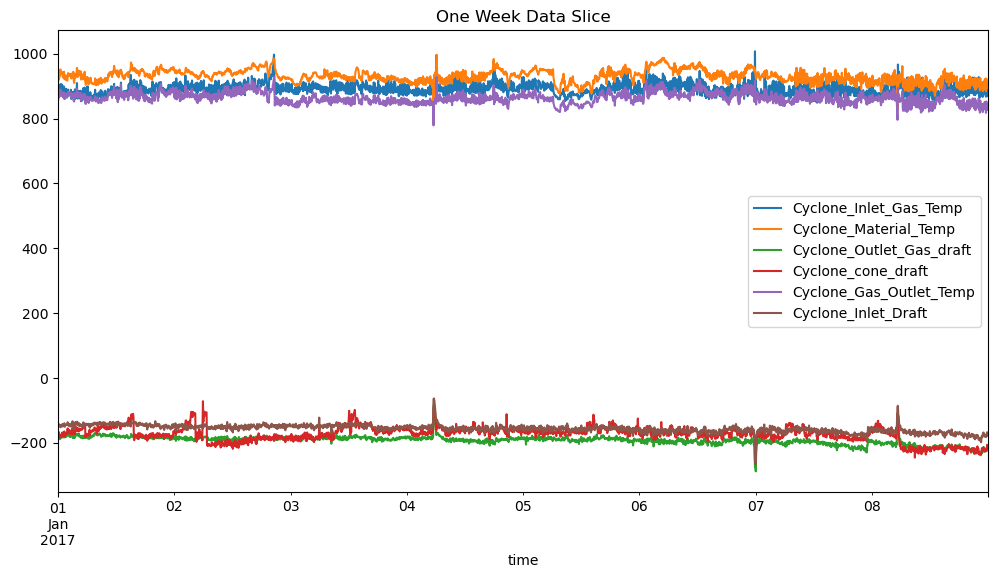

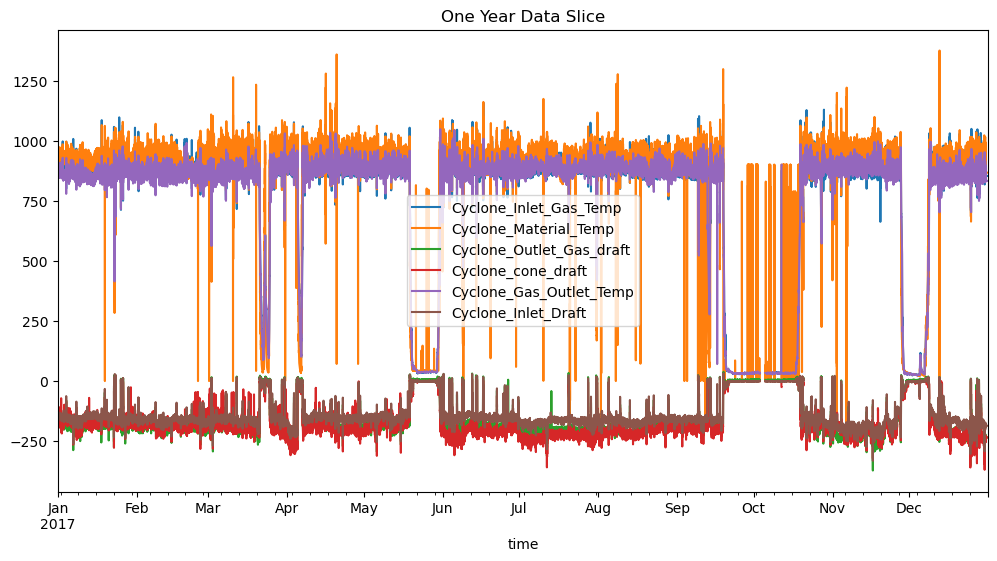

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize one week slice
one_week_data = df_resampled.loc['2017-01-01':'2017-01-08']
one_week_data.plot(figsize=(12,6))
plt.title("One Week Data Slice")
plt.show()

# Visualize one year slice
one_year_data = df_resampled.loc['2017-01-01':'2017-12-31']
one_year_data.plot(figsize=(12,6))
plt.title("One Year Data Slice")
plt.show()


Total downtime (minutes) over 3 years: 309070
Number of shutdown events: 62


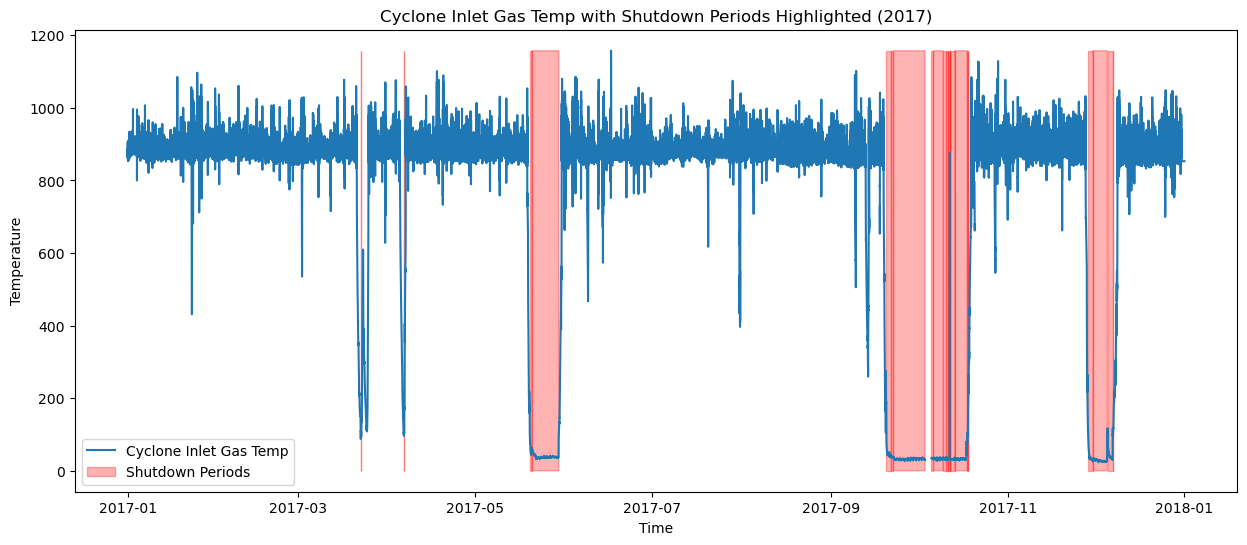

In [19]:
import pandas as pd
import matplotlib.pyplot as plt



# Step 1: Define shutdown/idle threshold on Cyclone_Inlet_Gas_Temp
shutdown_threshold = 100  # Adjust threshold based on domain knowledge
df_resampled['is_shutdown'] = df_resampled['Cyclone_Inlet_Gas_Temp'] < shutdown_threshold

# Step 2: Identify shutdown periods by grouping consecutive True shutdown flags
df_resampled['shutdown_group'] = (df_resampled['is_shutdown'] != df_resampled['is_shutdown'].shift()).cumsum()

# Step 3: Aggregate shutdown periods with start, end time and duration (count of 5-min intervals)
shutdown_periods = df_resampled[df_resampled['is_shutdown']].groupby('shutdown_group').agg(
    start_time=('is_shutdown', 'idxmin'),
    end_time=('is_shutdown', 'idxmax'),
    duration_intervals=('is_shutdown', 'size')
)

# Convert duration to minutes (5 minutes per interval)
shutdown_periods['duration_minutes'] = shutdown_periods['duration_intervals'] * 5

# Step 4: Compute total downtime and number of shutdown incidents across the dataset
total_downtime_minutes = shutdown_periods['duration_minutes'].sum()
num_shutdown_events = shutdown_periods.shape[0]

print(f"Total downtime (minutes) over 3 years: {total_downtime_minutes}")
print(f"Number of shutdown events: {num_shutdown_events}")

# Step 5: Visualize one full year (e.g., 2017) with shutdowns highlighted
one_year = df_resampled.loc['2017-01-01':'2017-12-31']

plt.figure(figsize=(15,6))
plt.plot(one_year.index, one_year['Cyclone_Inlet_Gas_Temp'], label='Cyclone Inlet Gas Temp')
plt.fill_between(one_year.index, 0, one_year['Cyclone_Inlet_Gas_Temp'].max(),
                 where=one_year['is_shutdown'], color='red', alpha=0.3, label='Shutdown Periods')
plt.title('Cyclone Inlet Gas Temp with Shutdown Periods Highlighted (2017)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [20]:
from sklearn.cluster import KMeans
import pandas as pd

# Filter active data (exclude shutdowns)
active_data = df_resampled[df_resampled['is_shutdown'] == False].copy()

# Feature engineering example: add rolling means and deltas
window = 3  # for rolling
for col in active_data.columns:
    if col not in ['is_shutdown', 'shutdown_group']:
        active_data[f'{col}_rollmean'] = active_data[col].rolling(window).mean()
        active_data[f'{col}_delta'] = active_data[col].diff()
# Drop rows with NaNs from rolling/diff
active_data = active_data.dropna()

# Select features for clustering
feature_cols = [c for c in active_data.columns if c not in ['is_shutdown', 'shutdown_group']]
X = active_data[feature_cols]

# Scale features if needed
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering example
k = 4  # number of states/clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

active_data['cluster'] = clusters

# Summarize clusters
cluster_summary = active_data.groupby('cluster').agg(['mean', 'std', 'count'])

print(cluster_summary)

# Calculate frequency and duration per cluster
# For duration: count consecutive runs of each cluster label
active_data['cluster_shift'] = active_data['cluster'].shift()
active_data['new_segment'] = active_data['cluster'] != active_data['cluster_shift']
active_data['segment_id'] = active_data['new_segment'].cumsum()

duration_stats = active_data.groupby(['cluster', 'segment_id']).size().groupby('cluster').agg(['count', 'mean', 'max'])

print(duration_stats)


        Cyclone_Inlet_Gas_Temp                     Cyclone_Material_Temp  \
                          mean         std   count                  mean   
cluster                                                                    
0                   900.988601   25.936791  106027            931.896077   
1                   403.872438  194.945765   18619            344.155989   
2                   888.679068   30.015857  101182            920.571972   
3                   886.788707   24.090765   88857            914.975004   

                            Cyclone_Outlet_Gas_draft                     \
                std   count                     mean        std   count   
cluster                                                                   
0         64.136091  106027              -252.472185  23.459918  106027   
1        293.864144   18619                 4.508312  12.940899   18619   
2         69.814992  101182              -191.371319  32.098128  101182   
3         76.0458

              start_time            end_time  duration_minutes  event_id  \
0    2017-01-02 06:45:00 2017-01-02 06:45:00                 1         1   
1    2017-01-03 06:00:00 2017-01-03 06:00:00                 1         3   
2    2017-01-04 05:30:00 2017-01-04 05:30:00                 1         5   
3    2017-01-06 23:50:00 2017-01-06 23:50:00                 1         7   
4    2017-01-08 05:10:00 2017-01-08 05:10:00                 2         9   
...                  ...                 ...               ...       ...   
1736 2020-07-27 18:40:00 2020-07-27 18:40:00                 1      3473   
1737 2020-07-30 10:00:00 2020-07-30 10:00:00                 3      3475   
1738 2020-07-30 12:05:00 2020-07-30 12:05:00                 2      3477   
1739 2020-07-30 14:50:00 2020-07-30 14:50:00                 1      3479   
1740 2020-08-01 08:20:00 2020-08-01 08:20:00                 2      3481   

                                          top_variables  
0     [Cyclone_Inlet_Gas_Temp

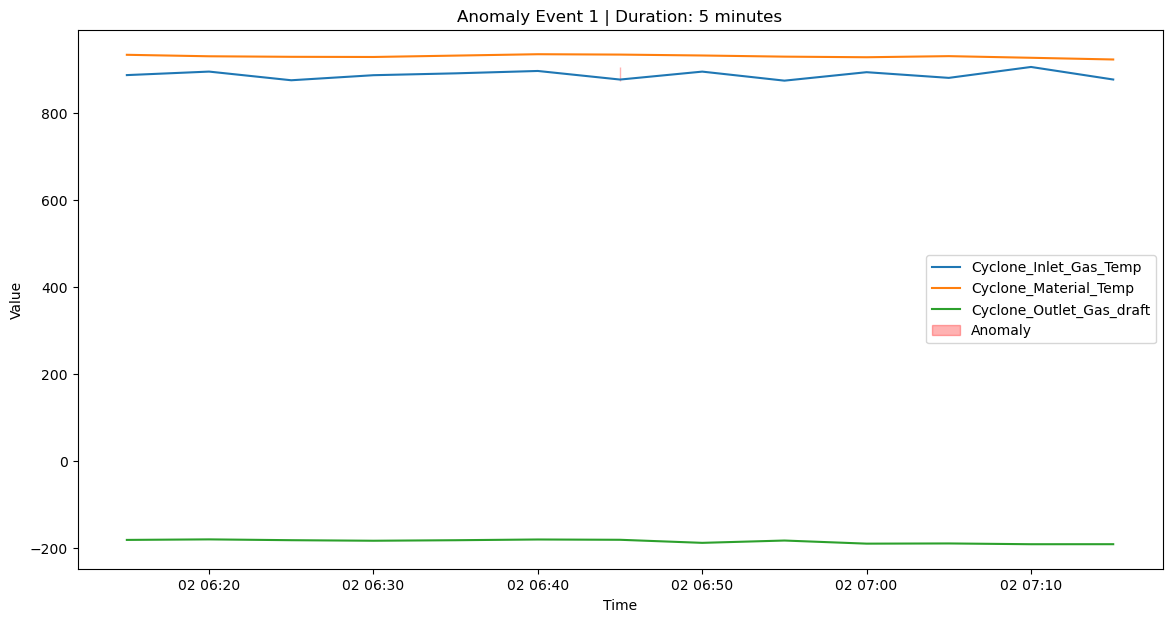

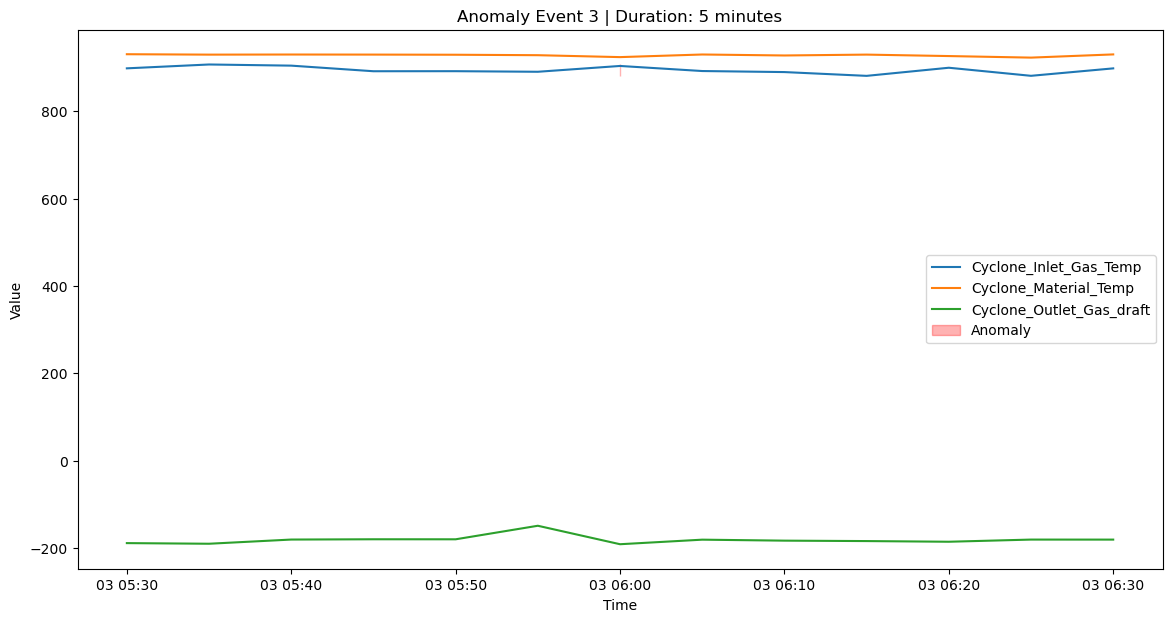

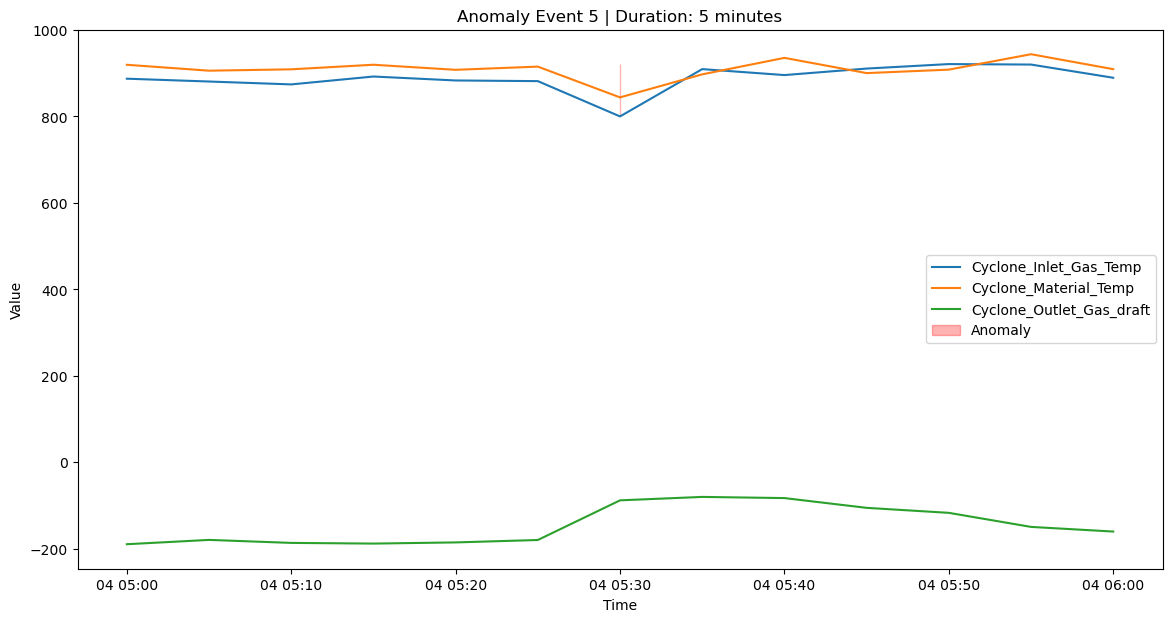

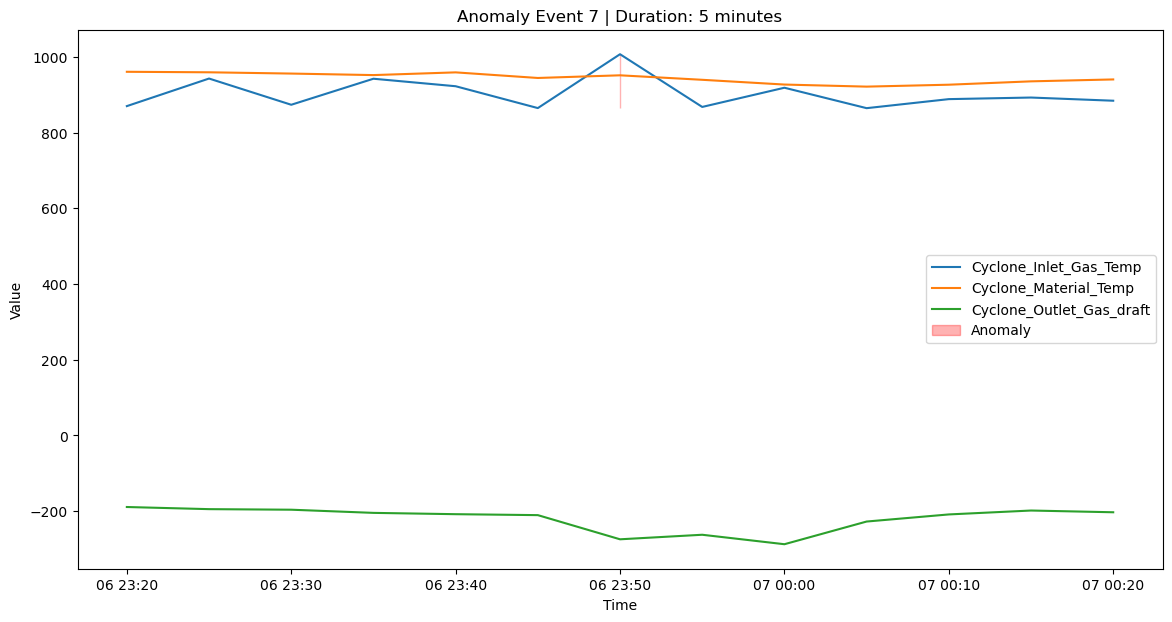

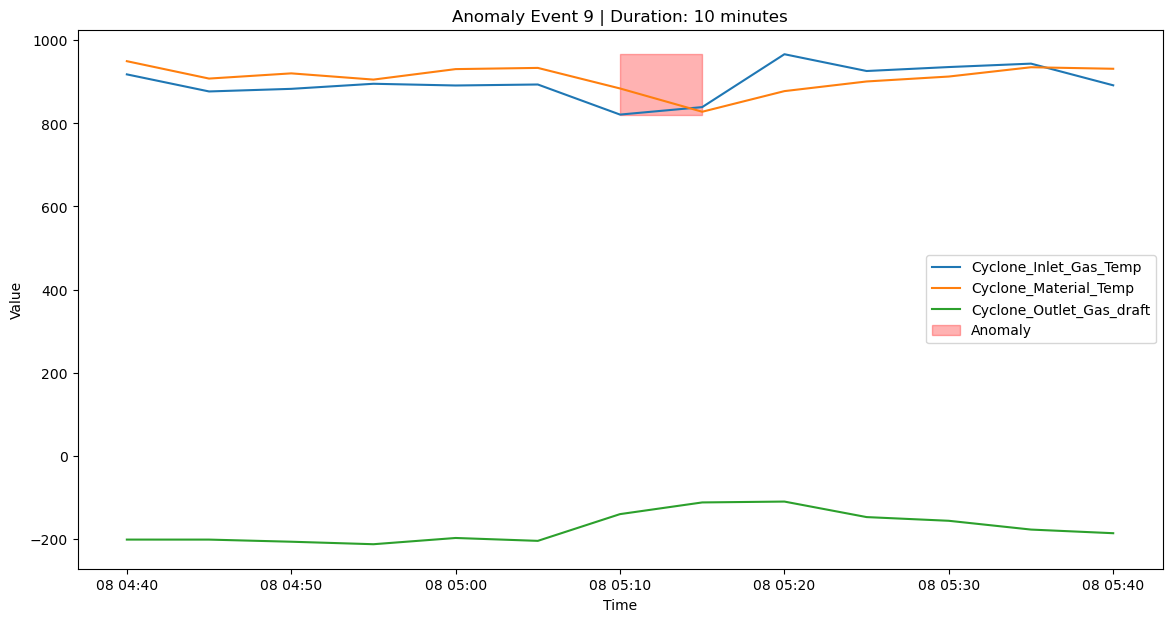

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Assuming active_data DataFrame exists with cluster labels and feature_cols defined

# 1. Contextual Anomaly Detection per cluster using Isolation Forest
anomaly_results = []

for cluster_label in active_data['cluster'].unique():
    cluster_data = active_data[active_data['cluster'] == cluster_label]
    
    X_cluster = cluster_data[feature_cols]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    iso_forest.fit(X_scaled)
    
    cluster_data = cluster_data.copy()
    cluster_data['anomaly'] = iso_forest.predict(X_scaled)
    anomaly_results.append(cluster_data[['anomaly']])

# Combine anomaly flags
active_data['anomaly'] = pd.concat(anomaly_results).sort_index()['anomaly']
active_data['anomaly'] = active_data['anomaly'] == -1  # True = anomaly

# 2. Consolidate anomalous events by grouping consecutive anomalies
active_data['anomaly_shift'] = active_data['anomaly'].shift(fill_value=False)
active_data['new_event'] = (active_data['anomaly'] != active_data['anomaly_shift'])
active_data['event_id'] = active_data['new_event'].cumsum()

anomalous_events = active_data[active_data['anomaly']].groupby('event_id').agg(
    start_time = ('anomaly', 'idxmin'),
    end_time = ('anomaly', 'idxmax'),
    duration_minutes = ('anomaly', 'size')
)

# Identify top implicated variables in each anomaly event
implicated_vars = []
for eid, group in active_data.groupby('event_id'):
    if group['anomaly'].iloc[0]:
        deviations = group[feature_cols].apply(lambda x: x.max() - x.min())
        top_vars = deviations.nlargest(3).index.tolist()
        implicated_vars.append((eid, top_vars))

implicated_df = pd.DataFrame(implicated_vars, columns=['event_id', 'top_variables'])
anomalous_events = anomalous_events.merge(implicated_df, left_index=True, right_on='event_id')

print(anomalous_events)

# 3. Root cause hypothesis framework (manual analysis required)
print("\nRoot cause hypotheses example:")
print("Example: 'A sudden drop in Cyclone_Gas_Outlet_Temp coincided with a spike in Cyclone_Inlet_Draft, indicating possible upstream draft surge or partial blockage clearing.'")

# 4. Visualize each chosen anomaly (first 5 for example)
for event_id in anomalous_events['event_id'].head(5):
    event = anomalous_events[anomalous_events['event_id'] == event_id].iloc[0]
    start, end = event['start_time'], event['end_time']
    time_window = active_data.loc[start - pd.Timedelta(minutes=30): end + pd.Timedelta(minutes=30)]

    plt.figure(figsize=(14,7))
    for var in feature_cols[:3]:  # plot first 3 vars for clarity
        plt.plot(time_window.index, time_window[var], label=var)
    plt.fill_between(time_window.index, time_window[feature_cols[0]].min(), time_window[feature_cols[0]].max(),
                     where=time_window['anomaly'], color='red', alpha=0.3, label='Anomaly')
    plt.title(f'Anomaly Event {event_id} | Duration: {event["duration_minutes"]*5} minutes')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


In [15]:

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Step 1: Load or define your active_data ---
# For demo purposes, creating sample data; replace with your actual data loading
date_rng = pd.date_range(start='2023-01-01', periods=30, freq='5min')
np.random.seed(42)
temp_values = 900 - np.arange(30) * 2 + np.random.normal(0, 1, 30)
active_data = pd.DataFrame({'Cyclone_Inlet_Gas_Temp': temp_values}, index=date_rng)

print(f"Original active_data shape: {active_data.shape}")

# --- Step 2: Create lag features ---
target = 'Cyclone_Inlet_Gas_Temp'
max_lag = 3  # Small lag to keep sufficient data

for lag in range(1, max_lag + 1):
    active_data[f'{target}_lag_{lag}'] = active_data[target].shift(lag)

active_data.dropna(inplace=True)
print(f"After lag features and dropna: {active_data.shape}")

# --- Step 3: Prepare features and target ---
feature_cols = [f'{target}_lag_{lag}' for lag in range(1, max_lag + 1)]
X = active_data[feature_cols]
y = active_data[target]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# --- Step 4: Train-test split (80-20 chronological) ---
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# --- Step 5: Persistence baseline forecasting ---
def persistence_forecast(last_value, steps=max_lag):
    return [last_value] * steps

persistence_preds = []
y_test_rolled = []

for i in range(len(X_test) - max_lag):
    last_val = X_test.iloc[i][f'{target}_lag_1']
    preds = persistence_forecast(last_val, steps=max_lag)
    persistence_preds.extend(preds)
    actual_vals = y_test.iloc[i+1:i+1+max_lag].values
    y_test_rolled.extend(actual_vals)

# --- Step 6: Random Forest forecasting ---
rf = RandomForestRegressor(random_state=42, n_estimators=50)
rf.fit(X_train, y_train)

def rf_multi_step_predict(model, input_features, steps=max_lag):
    preds = []
    features = list(input_features)
    for _ in range(steps):
        features_df = pd.DataFrame([features], columns=feature_cols)
        pred = model.predict(features_df)[0]
        preds.append(pred)
        features = [pred] + features[:-1]
    return preds

rf_preds = []
for i in range(len(X_test) - max_lag):
    input_features = X_test.iloc[i].values
    preds_ = rf_multi_step_predict(rf, input_features, steps=max_lag)
    rf_preds.extend(preds_)

# Align y_true length and rf_preds length
y_true = y_test.iloc[max_lag:max_lag + len(rf_preds)]

# --- Step 7: Evaluation ---
min_len_rf = min(len(y_true), len(rf_preds))
min_len_persistence = min(len(y_test_rolled), len(persistence_preds))

rmse_rf = np.sqrt(mean_squared_error(y_true.iloc[:min_len_rf], rf_preds[:min_len_rf]))
mae_rf = mean_absolute_error(y_true.iloc[:min_len_rf], rf_preds[:min_len_rf])

rmse_persistence = np.sqrt(mean_squared_error(y_test_rolled[:min_len_persistence], persistence_preds[:min_len_persistence]))
mae_persistence = mean_absolute_error(y_test_rolled[:min_len_persistence], persistence_preds[:min_len_persistence])

print(f"Persistence Baseline -> RMSE: {rmse_persistence:.3f}, MAE: {mae_persistence:.3f}")
print(f"Random Forest        -> RMSE: {rmse_rf:.3f}, MAE: {mae_rf:.3f}")

# --- Step 8: Discussion ---
print("\nPerformance Discussion:")
print("- Persistence baseline predicts next values equal to last observed, simple benchmark.")
print("- Random Forest learns from lagged features to improve predictions.")
print("- Using DataFrame input for prediction fixes feature name warnings.")
print("- Evaluations done on consistent-length true and predicted values.")













Original active_data shape: (30, 1)
After lag features and dropna: (27, 4)
Feature matrix shape: (27, 3)
Target vector shape: (27,)
Train shape: (21, 3), Test shape: (6, 3)
Persistence Baseline -> RMSE: 5.952, MAE: 5.665
Random Forest        -> RMSE: 10.911, MAE: 10.739

Performance Discussion:
- Persistence baseline predicts next values equal to last observed, simple benchmark.
- Random Forest learns from lagged features to improve predictions.
- Using DataFrame input for prediction fixes feature name warnings.
- Evaluations done on consistent-length true and predicted values.


Cluster with highest anomaly count: 1
Percentage of anomalies near shutdown: 0.00%
Average forecasting error by cluster: 
cluster_label
0    1.044673
1    1.164459
2    1.102936
Name: error, dtype: float64


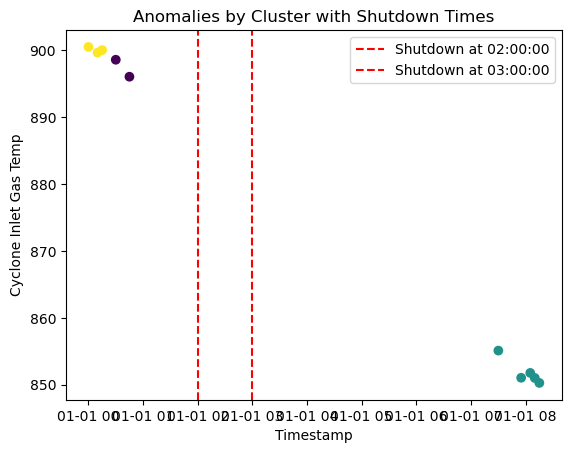

In [1]:

import os
os.environ["OMP_NUM_THREADS"] = "1"  # Must be set before importing sklearn

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Simulated example data: time series with timestamps
np.random.seed(42)
date_rng = pd.date_range(start='2023-01-01', periods=100, freq='5min')
values = 900 - np.arange(100) * 0.5 + np.random.normal(0, 1, 100)
data = pd.DataFrame({'timestamp': date_rng, 'Cyclone_Inlet_Gas_Temp': values})

# --- 1. Anomaly Detection using Isolation Forest ---
iso = IsolationForest(contamination=0.1, random_state=42)
data['anomaly_score'] = iso.fit_predict(data[['Cyclone_Inlet_Gas_Temp']])
data['anomaly'] = (data['anomaly_score'] == -1).astype(int)

# Extract anomalies DataFrame
anomalies_df = data[data['anomaly'] == 1][['timestamp', 'Cyclone_Inlet_Gas_Temp']].copy()

# --- 2. Clustering using KMeans on anomalies ---
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
anomalies_df['cluster_label'] = kmeans.fit_predict(anomalies_df[['Cyclone_Inlet_Gas_Temp']])

# --- 3. Define example shutdown times ---
shutdown_times = pd.to_datetime([
    '2023-01-01 02:00:00',
    '2023-01-01 03:00:00'
])

# --- 4. Forecast results example ---
forecast_results_df = data[['Cyclone_Inlet_Gas_Temp']].copy()
forecast_results_df['actual'] = forecast_results_df['Cyclone_Inlet_Gas_Temp']
forecast_results_df['predicted'] = forecast_results_df['Cyclone_Inlet_Gas_Temp'].shift(1).bfill()
forecast_results_df['cluster_label'] = np.random.choice(range(k), len(forecast_results_df))

# ----- Analysis snippet -----
anomaly_counts = anomalies_df.groupby('cluster_label').size()

anomalies_df['time_to_shutdown'] = anomalies_df['timestamp'].apply(
    lambda t: min([abs((t - sd).total_seconds()) for sd in shutdown_times])
)

close_to_shutdown = anomalies_df[
    (anomalies_df['time_to_shutdown'] >= 600) & 
    (anomalies_df['time_to_shutdown'] <= 1800)
]

forecast_results_df['error'] = abs(forecast_results_df['actual'] - forecast_results_df['predicted'])
error_summary = forecast_results_df.groupby('cluster_label')['error'].mean()

print(f"Cluster with highest anomaly count: {anomaly_counts.idxmax()}")
print(f"Percentage of anomalies near shutdown: {len(close_to_shutdown) / len(anomalies_df) * 100:.2f}%")
print(f"Average forecasting error by cluster: \n{error_summary}")

# Plot anomalies by cluster with shutdown times
plt.scatter(anomalies_df['timestamp'], anomalies_df['Cyclone_Inlet_Gas_Temp'], c=anomalies_df['cluster_label'])
for sd in shutdown_times:
    plt.axvline(x=sd, color='r', linestyle='--', label=f'Shutdown at {sd.time()}')
plt.legend()
plt.title('Anomalies by Cluster with Shutdown Times')
plt.xlabel('Timestamp')
plt.ylabel('Cyclone Inlet Gas Temp')
plt.show()



